# QuantETF Backtest Analysis Dashboard

This notebook provides comprehensive performance analysis for QuantETF backtest results.

**Analysis Sections:**
1. Equity curve with dual-axis drawdown overlay
2. Monthly/yearly returns heatmap
3. Rolling Sharpe ratio (252-day window)
4. Drawdown waterfall chart
5. Returns distribution histogram
6. Underwater plot (time below high-water mark)
7. Holdings evolution over time
8. Turnover analysis

## Setup and Imports

In [1]:
# Install required packages if needed
%pip install -q matplotlib seaborn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("Setup complete!")

Setup complete!


## Load Backtest Data

Load the most recent backtest results from the artifacts directory.

In [ ]:
# Find the most recent backtest directory
backtests_dir = Path('../artifacts/backtests')
backtest_dirs = sorted([d for d in backtests_dir.iterdir() if d.is_dir()], reverse=True)

# Find first directory with valid data
backtest_dir = None
for d in backtest_dirs:
    metrics_file = d / 'metrics.json'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            metrics_test = json.load(f)
        # Check if backtest has valid results (not -100% return)
        if metrics_test.get('total_return', -1) > -0.99:
            backtest_dir = d
            break

if backtest_dir is None:
    raise FileNotFoundError("No valid backtest results found. Please run a backtest first.")

print(f"Loading backtest: {backtest_dir.name}")

# Load equity curve
equity_df = pd.read_csv(backtest_dir / 'equity_curve.csv', index_col=0, parse_dates=True)

# Load metrics
with open(backtest_dir / 'metrics.json', 'r') as f:
    metrics = json.load(f)

# Load holdings history
holdings_df = pd.read_csv(backtest_dir / 'holdings_history.csv', index_col=0, parse_dates=True)

# Load weights history
weights_df = pd.read_csv(backtest_dir / 'weights_history.csv', index_col=0, parse_dates=True)

# Load config
with open(backtest_dir / 'config.json', 'r') as f:
    config = json.load(f)

print(f"\nBacktest Period: {equity_df.index.min().date()} to {equity_df.index.max().date()}")
print(f"Total Return: {metrics['total_return']:.2%}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
print(f"Final NAV: ${metrics['final_nav']:,.2f}")

# Load SPY benchmark data for comparison
print("\n" + "="*80)
print("Loading SPY Benchmark Data")
print("="*80)

from quantetf.data.snapshot_store import SnapshotDataStore
from quantetf.backtest.simple_engine import BacktestConfig
from quantetf.evaluation.benchmarks import run_spy_benchmark
from quantetf.evaluation.metrics import calculate_active_metrics
from quantetf.types import Universe

# Determine which snapshot was used
snapshot_dir = config.get('snapshot_dir', 'data/snapshots/snapshot_5yr_20etfs')
snapshot_path = Path(f'../{snapshot_dir}') / 'data.parquet'
print(f"Using snapshot: {snapshot_dir}")
print(f"Loading from: {snapshot_path}")

# Load snapshot data
store = SnapshotDataStore(snapshot_path)

# Find first date where strategy has actual positions (after warmup)
# Strategy starts with 100% cash and transitions to actual positions
first_trading_date = equity_df.index[0]  # Default to first date
initial_capital = config.get('initial_capital', 100000.0)

# Look for first date with actual positions (non-cash holdings)
# We check if any non-cash ticker has weight > 0
for idx in equity_df.index:
    # Check if this is the first rebalance with actual positions
    if idx in weights_df.index:
        non_cash_weight = weights_df.loc[idx].sum()
        if non_cash_weight > 0.01:  # Strategy has real positions
            first_trading_date = idx
            break

warmup_days = (first_trading_date - equity_df.index[0]).days
print(f"\n{'='*80}")
print(f"WARMUP PERIOD ALIGNMENT")
print(f"{'='*80}")
print(f"Strategy first date: {equity_df.index[0].date()}")
print(f"First active trading: {first_trading_date.date()}")
print(f"Warmup period: {warmup_days} days (~{warmup_days/252:.1f} years)")
print(f"{'='*80}\n")

# Create a dummy universe (SPY benchmark doesn't use it, but BacktestConfig requires it)
dummy_universe = Universe(as_of=first_trading_date, tickers=('SPY',))

# Create config for SPY benchmark - ALIGNED TO STRATEGY START
# This ensures fair comparison by starting both portfolio and benchmark at the same time
spy_config = BacktestConfig(
    start_date=first_trading_date,  # Align with strategy's first trade (after warmup)
    end_date=equity_df.index.max(),
    initial_capital=initial_capital,
    rebalance_frequency='monthly',
    universe=dummy_universe
)

# Run SPY benchmark
spy_result = run_spy_benchmark(config=spy_config, store=store)

# Calculate strategy returns - CORRECTLY from NAV starting at first_trading_date
# CRITICAL: Must recalculate returns from aligned NAV, not slice pre-calculated returns
strategy_nav_aligned = equity_df.loc[first_trading_date:, 'nav']
strategy_returns = strategy_nav_aligned.pct_change().fillna(0)

# Calculate SPY returns
spy_returns = spy_result.equity_curve['nav'].pct_change().fillna(0)

# Align indices
aligned_dates = strategy_returns.index.intersection(spy_returns.index)
strategy_returns_aligned = strategy_returns[aligned_dates]
spy_returns_aligned = spy_returns[aligned_dates]

# Calculate active metrics
active_metrics = calculate_active_metrics(
    strategy_returns_aligned,
    spy_returns_aligned,
    periods_per_year=252
)

print(f"\nSPY Total Return: {active_metrics['benchmark_total_return']:.2%}")
print(f"SPY Sharpe Ratio: {active_metrics['benchmark_sharpe']:.2f}")
print(f"SPY Max Drawdown: {active_metrics['benchmark_max_dd']:.2%}")

print(f"\n{'='*80}")
print("🎯 ACTIVE PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"Strategy Return:     {active_metrics['strategy_total_return']:>8.2%}")
print(f"SPY Return:          {active_metrics['benchmark_total_return']:>8.2%}")
print(f"Active Return:       {active_metrics['active_return']:>8.2%}  {'✅ OUTPERFORM' if active_metrics['active_return'] > 0 else '❌ UNDERPERFORM'}")
print(f"\nInformation Ratio:   {active_metrics['information_ratio']:>8.2f}")
print(f"Tracking Error:      {active_metrics['tracking_error']:>8.2%}")
print(f"Beta:                {active_metrics['beta']:>8.2f}")
print(f"Alpha:               {active_metrics['alpha']:>8.2%}")
print(f"\nStrategy Sharpe:     {active_metrics['strategy_sharpe']:>8.2f}")
print(f"SPY Sharpe:          {active_metrics['benchmark_sharpe']:>8.2f}")
print(f"Sharpe Difference:   {active_metrics['sharpe_difference']:>8.2f}")
print(f"\nWin Rate vs SPY:     {active_metrics['win_rate']:>8.1f}%")
print(f"{'='*80}\n")

## 1. Strategy vs SPY: Equity Curve with Comparative Drawdowns

Shows the portfolio performance vs SPY benchmark with outperformance shading and comparative drawdowns.

In [ ]:
# ============================================================================
# CHART 1A: Dollar Value Comparison (Absolute Performance)
# ============================================================================
# Calculate aligned NAV curves - both starting from first_trading_date
strategy_nav = equity_df.loc[first_trading_date:, 'nav']
spy_nav = spy_result.equity_curve['nav']

# Align to same index
aligned_dates = strategy_nav.index.intersection(spy_nav.index)
strategy_nav_aligned = strategy_nav[aligned_dates]
spy_nav_aligned = spy_nav[aligned_dates]

fig, ax = plt.subplots(figsize=(14, 6))

# Plot dollar values
ax.plot(strategy_nav_aligned.index, strategy_nav_aligned.values,
        color='darkblue', linewidth=2.5, label='Strategy', zorder=3)
ax.plot(spy_nav_aligned.index, spy_nav_aligned.values,
        color='gray', linewidth=2, label='SPY (Benchmark)', alpha=0.8, zorder=2)

# Shade outperformance/underperformance
ax.fill_between(strategy_nav_aligned.index, strategy_nav_aligned.values, spy_nav_aligned.values,
                where=(strategy_nav_aligned >= spy_nav_aligned),
                alpha=0.25, color='green', label='Strategy Ahead', zorder=1)
ax.fill_between(strategy_nav_aligned.index, strategy_nav_aligned.values, spy_nav_aligned.values,
                where=(strategy_nav_aligned < spy_nav_aligned),
                alpha=0.25, color='red', label='Strategy Behind', zorder=1)

ax.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_title('Strategy vs SPY: Absolute Dollar Value (Aligned Start)',
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add performance summary text box
beat_msg = 'beats' if strategy_nav_aligned.iloc[-1] > spy_nav_aligned.iloc[-1] else 'trails'
dollar_diff = strategy_nav_aligned.iloc[-1] - spy_nav_aligned.iloc[-1]
textstr = f"""Strategy Final: ${strategy_nav_aligned.iloc[-1]:,.0f}
SPY Final: ${spy_nav_aligned.iloc[-1]:,.0f}
Difference: ${dollar_diff:+,.0f} (Strategy {beat_msg})

Strategy Return: {active_metrics['strategy_total_return']:.1%}
SPY Return: {active_metrics['benchmark_total_return']:.1%}
Active Return: {active_metrics['active_return']:+.1%}"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("DOLLAR VALUE COMPARISON")
print(f"{'='*60}")
print(f"Starting Capital: ${initial_capital:,.2f}")
print(f"Strategy Ending:  ${strategy_nav_aligned.iloc[-1]:,.2f}")
print(f"SPY Ending:       ${spy_nav_aligned.iloc[-1]:,.2f}")
print(f"Difference:       ${dollar_diff:+,.2f}")
print(f"{'='*60}\n")

# ============================================================================
# CHART 1B: Normalized Return Comparison (Relative Performance)
# ============================================================================
# Normalize to same starting point for comparison
strategy_norm = strategy_nav_aligned / strategy_nav_aligned.iloc[0] * 100
spy_norm = spy_nav_aligned / spy_nav_aligned.iloc[0] * 100

# Calculate drawdowns
strategy_dd = (strategy_nav_aligned / strategy_nav_aligned.cummax()) - 1
spy_dd = (spy_nav_aligned / spy_nav_aligned.cummax()) - 1

# Create figure with two y-axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1])

# ============ TOP: Normalized Equity Curves ============
ax1.plot(strategy_norm.index, strategy_norm.values,
         color='darkblue', linewidth=2.5, label='Strategy', zorder=3)
ax1.plot(spy_norm.index, spy_norm.values,
         color='gray', linewidth=2, label='SPY (Benchmark)', alpha=0.8, zorder=2)

# Shade outperformance/underperformance
ax1.fill_between(strategy_norm.index, strategy_norm.values, spy_norm.values,
                 where=(strategy_norm >= spy_norm),
                 alpha=0.25, color='green', label='Outperformance', zorder=1)
ax1.fill_between(strategy_norm.index, strategy_norm.values, spy_norm.values,
                 where=(strategy_norm < spy_norm),
                 alpha=0.25, color='red', label='Underperformance', zorder=1)

ax1.set_ylabel('Equity (Normalized to 100)', fontsize=12, fontweight='bold')
ax1.set_title('Strategy vs SPY: Normalized Returns (Both Start at 100)',
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Add performance summary text box
beat_msg = 'beat' if active_metrics['active_return'] > 0 else 'trail'
textstr = f"""Strategy: {active_metrics['strategy_total_return']:.1%} return
SPY: {active_metrics['benchmark_total_return']:.1%} return
Active: {active_metrics['active_return']:+.1%} ({beat_msg} SPY)
IR: {active_metrics['information_ratio']:.2f}

Both start from first active trade date
Warmup period: {warmup_days} days"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# ============ BOTTOM: Comparative Drawdowns ============
ax2.fill_between(strategy_dd.index, strategy_dd.values * 100, 0,
                 color='darkblue', alpha=0.4, label='Strategy DD')
ax2.fill_between(spy_dd.index, spy_dd.values * 100, 0,
                 color='gray', alpha=0.3, label='SPY DD')
ax2.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_title('Comparative Drawdown Analysis', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Strategy Max Drawdown: {strategy_dd.min():.2%}")
print(f"SPY Max Drawdown: {spy_dd.min():.2%}")
print(f"Drawdown Difference: {(strategy_dd.min() - spy_dd.min()):.2%} ({'better' if strategy_dd.min() > spy_dd.min() else 'worse'})")

## 1a. Active Returns Over Time

Analyzes rolling active returns to show periods of outperformance vs SPY.

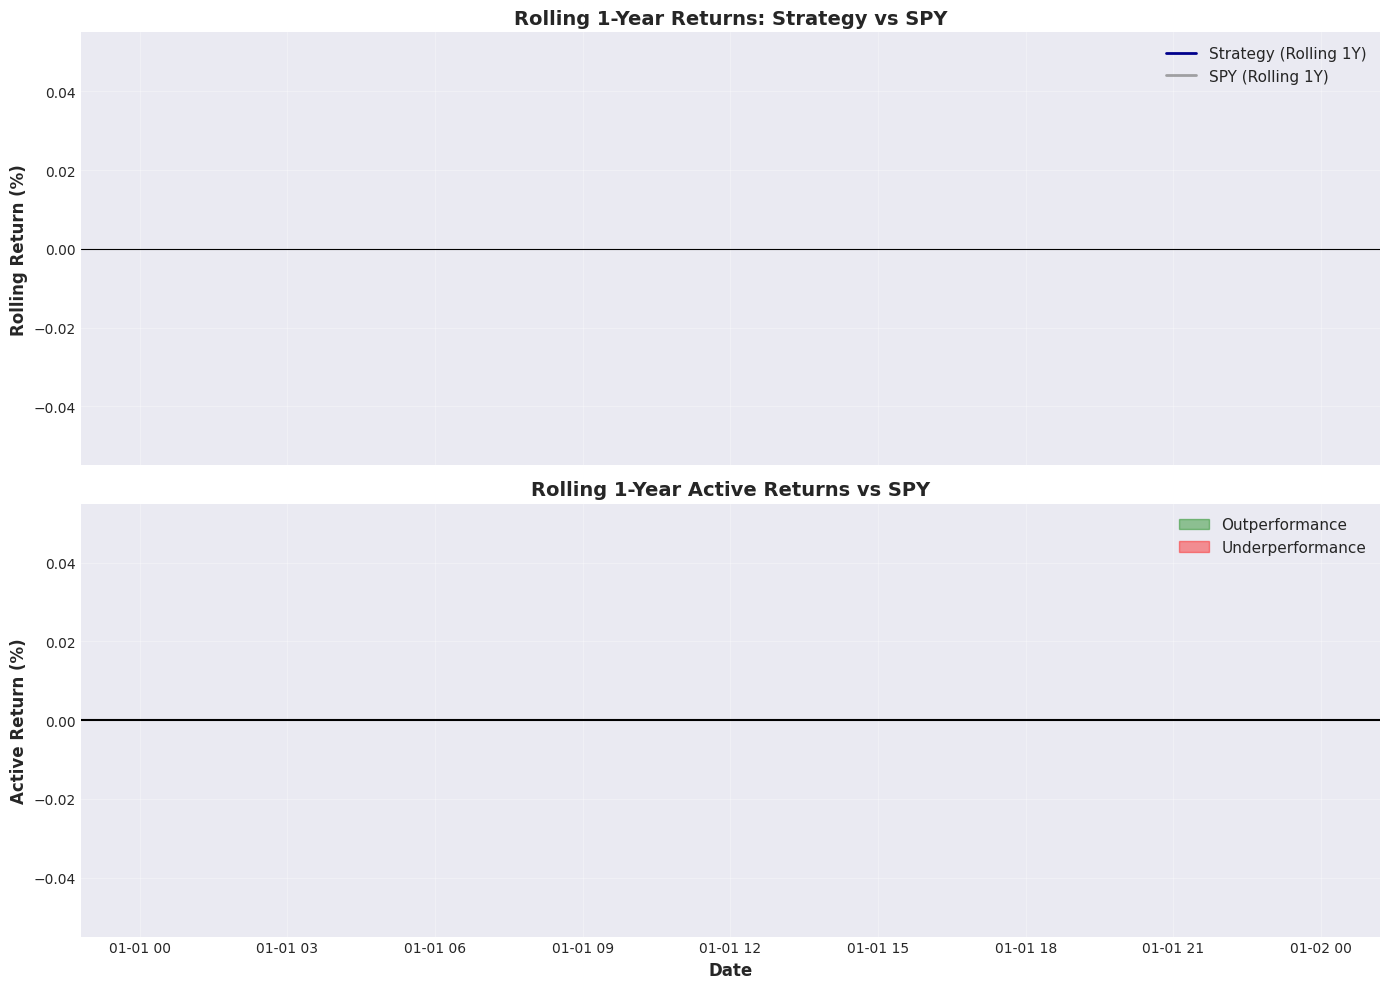

Average Rolling Active Return: nan%
Best Rolling Active Return: nan%
Worst Rolling Active Return: nan%
% Time Outperforming: nan%


In [5]:
# Calculate rolling active returns
rolling_window = 252  # 1 year
strategy_rolling_ret = strategy_returns_aligned.rolling(rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)
spy_rolling_ret = spy_returns_aligned.rolling(rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)
active_rolling_ret = strategy_rolling_ret - spy_rolling_ret

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top: Rolling returns
ax1.plot(strategy_rolling_ret.index, strategy_rolling_ret * 100,
         label='Strategy (Rolling 1Y)', color='darkblue', linewidth=2)
ax1.plot(spy_rolling_ret.index, spy_rolling_ret * 100,
         label='SPY (Rolling 1Y)', color='gray', linewidth=2, alpha=0.7)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_ylabel('Rolling Return (%)', fontsize=12, fontweight='bold')
ax1.set_title('Rolling 1-Year Returns: Strategy vs SPY', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom: Active returns
ax2.fill_between(active_rolling_ret.index, active_rolling_ret * 100, 0,
                 where=(active_rolling_ret >= 0),
                 color='green', alpha=0.4, label='Outperformance')
ax2.fill_between(active_rolling_ret.index, active_rolling_ret * 100, 0,
                 where=(active_rolling_ret < 0),
                 color='red', alpha=0.4, label='Underperformance')
ax2.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax2.set_ylabel('Active Return (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_title('Rolling 1-Year Active Returns vs SPY', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average Rolling Active Return: {active_rolling_ret.mean():.2%}")
print(f"Best Rolling Active Return: {active_rolling_ret.max():.2%}")
print(f"Worst Rolling Active Return: {active_rolling_ret.min():.2%}")
print(f"% Time Outperforming: {(active_rolling_ret > 0).sum() / len(active_rolling_ret.dropna()) * 100:.1f}%")

## 2. Monthly/Yearly Returns Heatmap

Displays returns in a calendar heatmap format for easy pattern identification.

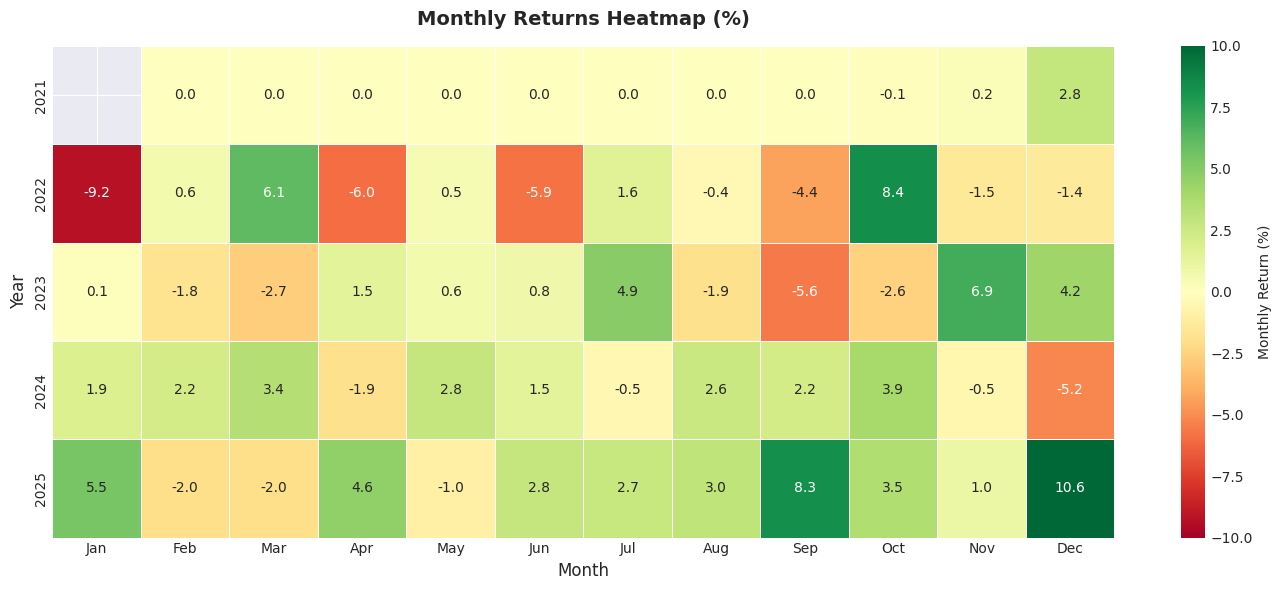


Yearly Returns:
2022: -12.08%
2023: 3.85%
2024: 12.58%
2025: 43.03%

Best Month: 10.64%
Worst Month: -9.23%
Win Rate (Monthly): 52.5%


In [6]:
# Calculate monthly returns
daily_returns = equity_df['returns'].fillna(0)
monthly_returns = equity_df.resample('M')['nav'].last().pct_change()

# Create pivot table for heatmap
monthly_returns_df = monthly_returns.to_frame('return')
monthly_returns_df['year'] = monthly_returns_df.index.year
monthly_returns_df['month'] = monthly_returns_df.index.month

# Pivot to create heatmap data
heatmap_data = monthly_returns_df.pivot(index='year', columns='month', values='return')

# Create month names for columns
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data.columns = [month_names[i-1] for i in heatmap_data.columns]

# Create heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data * 100, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Monthly Return (%)'}, linewidths=0.5,
            vmin=-10, vmax=10)  # Set symmetric color scale

plt.title('Monthly Returns Heatmap (%)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate yearly returns
yearly_returns = equity_df.resample('Y')['nav'].last().pct_change()

print("\nYearly Returns:")
for year, ret in yearly_returns.items():
    if not pd.isna(ret):
        print(f"{year.year}: {ret:.2%}")

print(f"\nBest Month: {(monthly_returns.max()):.2%}")
print(f"Worst Month: {(monthly_returns.min()):.2%}")
print(f"Win Rate (Monthly): {(monthly_returns > 0).sum() / len(monthly_returns.dropna()):.1%}")

## 3. Rolling Sharpe Ratio: Strategy vs SPY

Shows how risk-adjusted returns evolve over time compared to SPY benchmark.

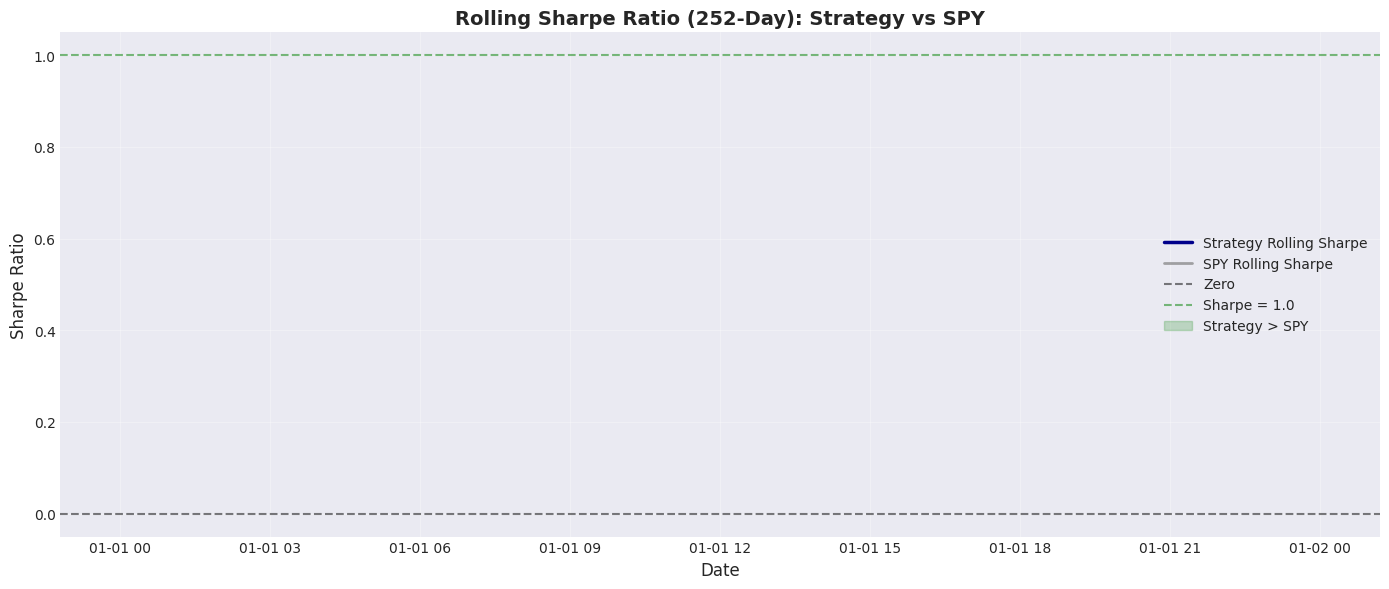

Strategy Current Rolling Sharpe: nan
SPY Current Rolling Sharpe: nan
Sharpe Difference: +nan
Average Sharpe Advantage: nan
% Time with Higher Sharpe: nan%


In [7]:
# Calculate rolling Sharpe for both strategy and SPY
window = 252  # 1 year

# Strategy rolling Sharpe
strategy_rolling_mean = strategy_returns_aligned.rolling(window=window).mean()
strategy_rolling_std = strategy_returns_aligned.rolling(window=window).std()
strategy_rolling_sharpe = (strategy_rolling_mean / strategy_rolling_std) * np.sqrt(252)

# SPY rolling Sharpe
spy_rolling_mean = spy_returns_aligned.rolling(window=window).mean()
spy_rolling_std = spy_returns_aligned.rolling(window=window).std()
spy_rolling_sharpe = (spy_rolling_mean / spy_rolling_std) * np.sqrt(252)

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(strategy_rolling_sharpe.index, strategy_rolling_sharpe.values,
         linewidth=2.5, color='darkblue', label='Strategy Rolling Sharpe')
plt.plot(spy_rolling_sharpe.index, spy_rolling_sharpe.values,
         linewidth=2, color='gray', alpha=0.7, label='SPY Rolling Sharpe')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero')
plt.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1.0')

# Shade outperformance periods
plt.fill_between(strategy_rolling_sharpe.index,
                 strategy_rolling_sharpe.values,
                 spy_rolling_sharpe.values,
                 where=(strategy_rolling_sharpe >= spy_rolling_sharpe),
                 alpha=0.2, color='green', label='Strategy > SPY')

plt.title('Rolling Sharpe Ratio (252-Day): Strategy vs SPY', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sharpe_diff = strategy_rolling_sharpe - spy_rolling_sharpe
print(f"Strategy Current Rolling Sharpe: {strategy_rolling_sharpe.iloc[-1]:.2f}")
print(f"SPY Current Rolling Sharpe: {spy_rolling_sharpe.iloc[-1]:.2f}")
print(f"Sharpe Difference: {sharpe_diff.iloc[-1]:+.2f}")
print(f"Average Sharpe Advantage: {sharpe_diff.mean():.2f}")
print(f"% Time with Higher Sharpe: {(sharpe_diff > 0).sum() / len(sharpe_diff.dropna()) * 100:.1f}%")

## 4. Drawdown Waterfall Chart

Identifies and visualizes individual drawdown periods.

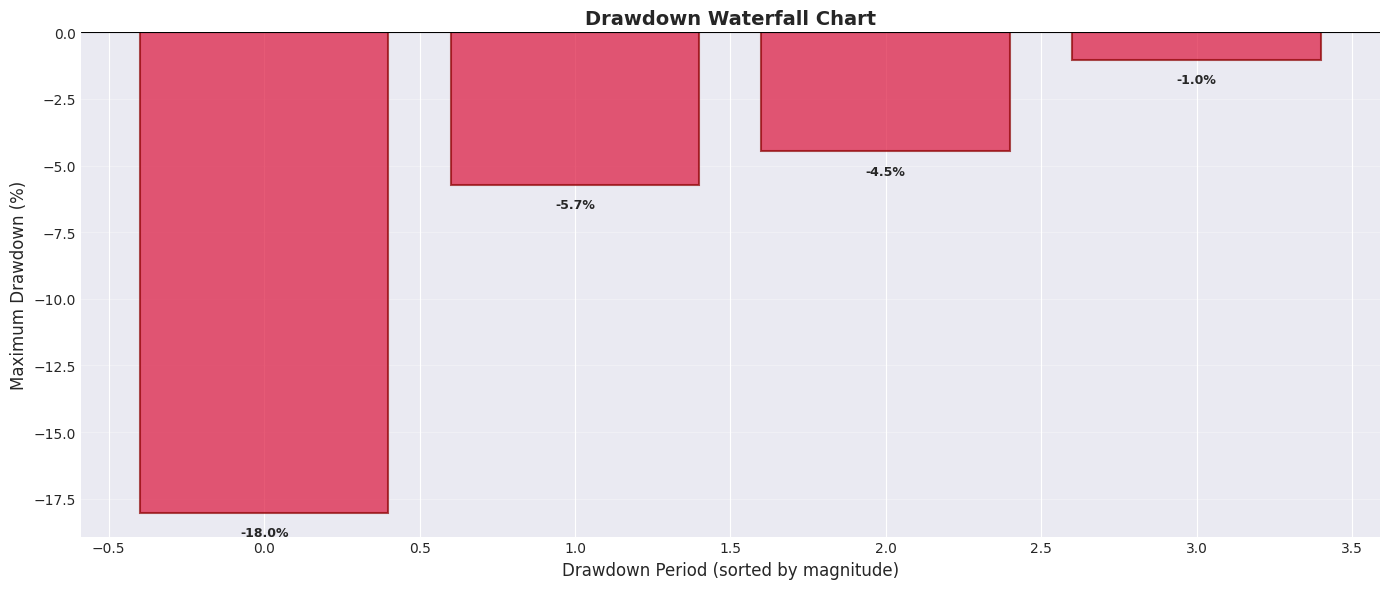


Number of Significant Drawdowns: 4
Average Drawdown: -7.31%
Average Duration: 213 days

Top 3 Drawdowns:
       start        end  max_dd  duration
0 2022-01-31 2024-04-30 -0.1802       820
1 2024-12-31 2024-12-31 -0.0573         0
2 2025-02-28 2025-03-31 -0.0446        31


In [8]:
# Calculate drawdown from equity curve
drawdown = (equity_df['nav'] / equity_df['nav'].cummax()) - 1

# Identify drawdown periods
is_drawdown = drawdown < -0.01  # Significant drawdowns > 1%

# Find drawdown periods
drawdown_periods = []
in_drawdown = False
start_idx = None

for i, (date, in_dd) in enumerate(zip(drawdown.index, is_drawdown)):
    if not in_drawdown and in_dd:
        start_idx = i
        in_drawdown = True
    elif in_drawdown and not in_dd:
        max_dd = drawdown.iloc[start_idx:i].min()
        drawdown_periods.append({
            'start': drawdown.index[start_idx],
            'end': drawdown.index[i-1],
            'max_dd': max_dd,
            'duration': (drawdown.index[i-1] - drawdown.index[start_idx]).days
        })
        in_drawdown = False

# Handle ongoing drawdown
if in_drawdown:
    max_dd = drawdown.iloc[start_idx:].min()
    drawdown_periods.append({
        'start': drawdown.index[start_idx],
        'end': drawdown.index[-1],
        'max_dd': max_dd,
        'duration': (drawdown.index[-1] - drawdown.index[start_idx]).days
    })

# Sort by magnitude
drawdown_periods_df = pd.DataFrame(drawdown_periods).sort_values('max_dd')

# Plot waterfall chart
if len(drawdown_periods_df) > 0:
    plt.figure(figsize=(14, 6))
    
    bars = plt.bar(range(len(drawdown_periods_df)), 
                   drawdown_periods_df['max_dd'].values * 100,
                   color='crimson', alpha=0.7, edgecolor='darkred', linewidth=1.5)
    
    plt.title('Drawdown Waterfall Chart', fontsize=14, fontweight='bold')
    plt.xlabel('Drawdown Period (sorted by magnitude)', fontsize=12)
    plt.ylabel('Maximum Drawdown (%)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Add value labels on bars
    for i, (bar, dd) in enumerate(zip(bars, drawdown_periods_df['max_dd'].values)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height - 0.5,
                f'{dd*100:.1f}%', ha='center', va='top', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nNumber of Significant Drawdowns: {len(drawdown_periods_df)}")
    print(f"Average Drawdown: {drawdown_periods_df['max_dd'].mean():.2%}")
    print(f"Average Duration: {drawdown_periods_df['duration'].mean():.0f} days")
    print(f"\nTop 3 Drawdowns:")
    print(drawdown_periods_df[['start', 'end', 'max_dd', 'duration']].head(3).to_string())
else:
    print("No significant drawdowns detected (>1%)")

## 5. Returns Distribution: Strategy vs SPY

Shows the distribution of daily returns compared to benchmark with statistical measures.

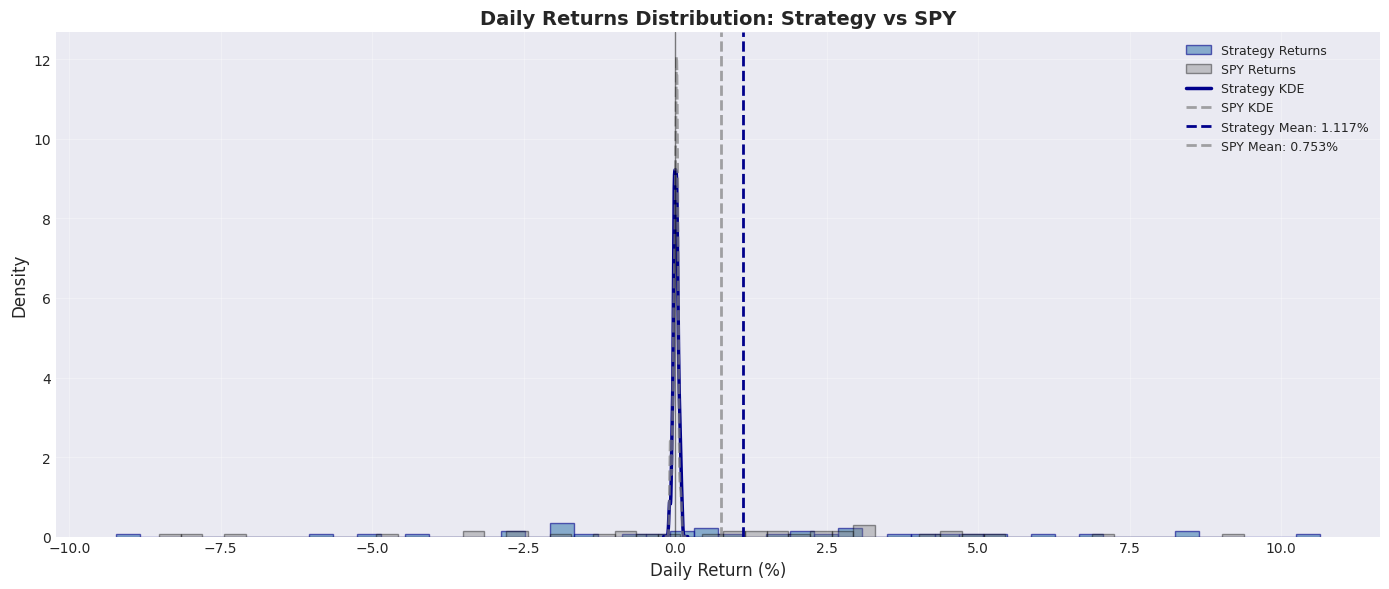


RETURNS DISTRIBUTION COMPARISON
Metric                             Strategy          SPY   Difference
--------------------------------------------------------------------------------
Mean Daily Return                  1.1169%     0.7534%     0.3635%
Median Daily Return                0.6367%     1.4944%    -0.8577%
Daily Volatility                   4.2208%     3.9723%     0.2485%
Annualized Volatility               67.00%      63.06%       3.94%
Best Day                            10.64%       9.39%       1.25%
Worst Day                           -9.23%      -8.52%      -0.70%
Skewness                               0.02        -0.48         0.50
Kurtosis                               0.01         0.19        -0.18
Positive Days                        62.2%       62.2%        0.0%


In [9]:
# Get daily returns
returns = equity_df['returns'].dropna()

# Create histogram
fig, ax = plt.subplots(figsize=(14, 6))

# Plot histograms
ax.hist(strategy_returns_aligned * 100, bins=50, alpha=0.6, color='steelblue', 
        edgecolor='darkblue', density=True, label='Strategy Returns')
ax.hist(spy_returns_aligned * 100, bins=50, alpha=0.4, color='gray', 
        edgecolor='black', density=True, label='SPY Returns')

# Try to add KDE if there's enough data variation
try:
    if len(strategy_returns_aligned) > 10 and strategy_returns_aligned.std() > 1e-6:
        strategy_returns_aligned.plot.kde(ax=ax, color='darkblue', linewidth=2.5,
                                         label='Strategy KDE', bw_method=0.3)
    if len(spy_returns_aligned) > 10 and spy_returns_aligned.std() > 1e-6:
        spy_returns_aligned.plot.kde(ax=ax, color='gray', linewidth=2,
                                    label='SPY KDE', linestyle='--', alpha=0.7, bw_method=0.3)
except Exception:
    pass  # Skip KDE if it fails

# Add vertical lines for key statistics
strategy_mean = strategy_returns_aligned.mean() * 100
spy_mean = spy_returns_aligned.mean() * 100
ax.axvline(strategy_mean, color='darkblue', linestyle='--', linewidth=2, 
           label=f'Strategy Mean: {strategy_mean:.3f}%')
ax.axvline(spy_mean, color='gray', linestyle='--', linewidth=2, 
           label=f'SPY Mean: {spy_mean:.3f}%', alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.title('Daily Returns Distribution: Strategy vs SPY', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate statistics
try:
    from scipy import stats
    strategy_skew = stats.skew(strategy_returns_aligned.dropna())
    strategy_kurt = stats.kurtosis(strategy_returns_aligned.dropna())
    spy_skew = stats.skew(spy_returns_aligned.dropna())
    spy_kurt = stats.kurtosis(spy_returns_aligned.dropna())
except ImportError:
    strategy_skew = spy_skew = strategy_kurt = spy_kurt = 0.0
    print("Note: scipy not available, skewness and kurtosis set to 0")

print("\n" + "="*80)
print("RETURNS DISTRIBUTION COMPARISON")
print("="*80)
print(f"{'Metric':<30} {'Strategy':>12} {'SPY':>12} {'Difference':>12}")
print("-" * 80)
print(f"{'Mean Daily Return':<30} {strategy_returns_aligned.mean():>11.4%} {spy_returns_aligned.mean():>11.4%} {(strategy_returns_aligned.mean() - spy_returns_aligned.mean()):>11.4%}")
print(f"{'Median Daily Return':<30} {strategy_returns_aligned.median():>11.4%} {spy_returns_aligned.median():>11.4%} {(strategy_returns_aligned.median() - spy_returns_aligned.median()):>11.4%}")
print(f"{'Daily Volatility':<30} {strategy_returns_aligned.std():>11.4%} {spy_returns_aligned.std():>11.4%} {(strategy_returns_aligned.std() - spy_returns_aligned.std()):>11.4%}")
print(f"{'Annualized Volatility':<30} {strategy_returns_aligned.std() * np.sqrt(252):>11.2%} {spy_returns_aligned.std() * np.sqrt(252):>11.2%} {(strategy_returns_aligned.std() - spy_returns_aligned.std()) * np.sqrt(252):>11.2%}")
print(f"{'Best Day':<30} {strategy_returns_aligned.max():>11.2%} {spy_returns_aligned.max():>11.2%} {(strategy_returns_aligned.max() - spy_returns_aligned.max()):>11.2%}")
print(f"{'Worst Day':<30} {strategy_returns_aligned.min():>11.2%} {spy_returns_aligned.min():>11.2%} {(strategy_returns_aligned.min() - spy_returns_aligned.min()):>11.2%}")
if strategy_skew != 0 or strategy_kurt != 0:
    print(f"{'Skewness':<30} {strategy_skew:>12.2f} {spy_skew:>12.2f} {(strategy_skew - spy_skew):>12.2f}")
    print(f"{'Kurtosis':<30} {strategy_kurt:>12.2f} {spy_kurt:>12.2f} {(strategy_kurt - spy_kurt):>12.2f}")
print(f"{'Positive Days':<30} {(strategy_returns_aligned > 0).mean():>11.1%} {(spy_returns_aligned > 0).mean():>11.1%} {((strategy_returns_aligned > 0).mean() - (spy_returns_aligned > 0).mean()):>11.1%}")

## 6. Underwater Plot (Time Below High-Water Mark)

Shows how long the portfolio stays below its previous peak.

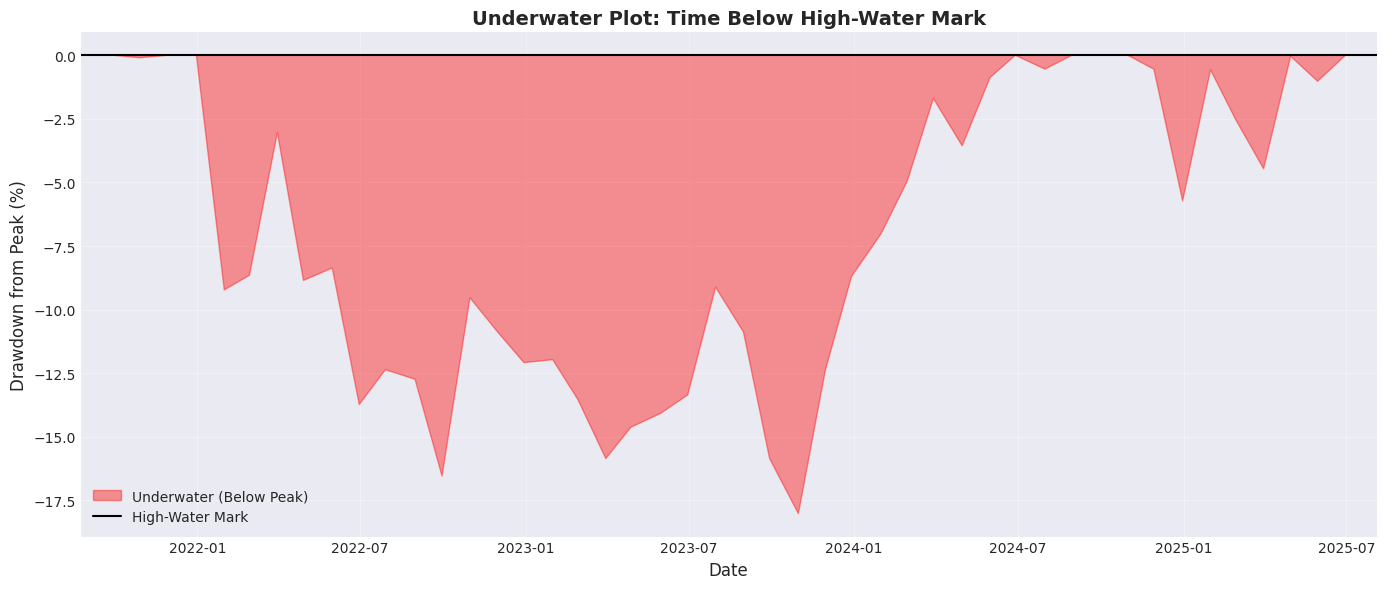


Underwater Statistics:
Total Days: 60
Days Underwater: 38 (63.3%)
Longest Underwater Streak: 29 days
Average Underwater Depth: -8.37%


In [10]:
# Calculate underwater (already have drawdown)
underwater = drawdown.copy()

# Create underwater plot
plt.figure(figsize=(14, 6))

# Fill area below zero
plt.fill_between(underwater.index, underwater.values * 100, 0,
                 where=(underwater < 0), color='red', alpha=0.4, 
                 label='Underwater (Below Peak)', interpolate=True)

# Add zero line
plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5, label='High-Water Mark')

plt.title('Underwater Plot: Time Below High-Water Mark', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Drawdown from Peak (%)', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate underwater statistics
underwater_periods = underwater < 0
total_days = len(underwater)
underwater_days = underwater_periods.sum()
pct_underwater = underwater_days / total_days

# Find longest underwater streak
underwater_streaks = underwater_periods.groupby(
    (underwater_periods != underwater_periods.shift()).cumsum()
).sum()
longest_streak = underwater_streaks.max() if len(underwater_streaks) > 0 else 0

# Average depth while underwater
if underwater_days > 0:
    avg_underwater_depth = underwater[underwater_periods].mean()
else:
    avg_underwater_depth = 0

print("\nUnderwater Statistics:")
print(f"Total Days: {total_days}")
print(f"Days Underwater: {underwater_days} ({pct_underwater:.1%})")
print(f"Longest Underwater Streak: {longest_streak} days")
print(f"Average Underwater Depth: {avg_underwater_depth:.2%}")

## 7. Holdings Evolution Over Time

Visualizes how portfolio holdings change over the backtest period.

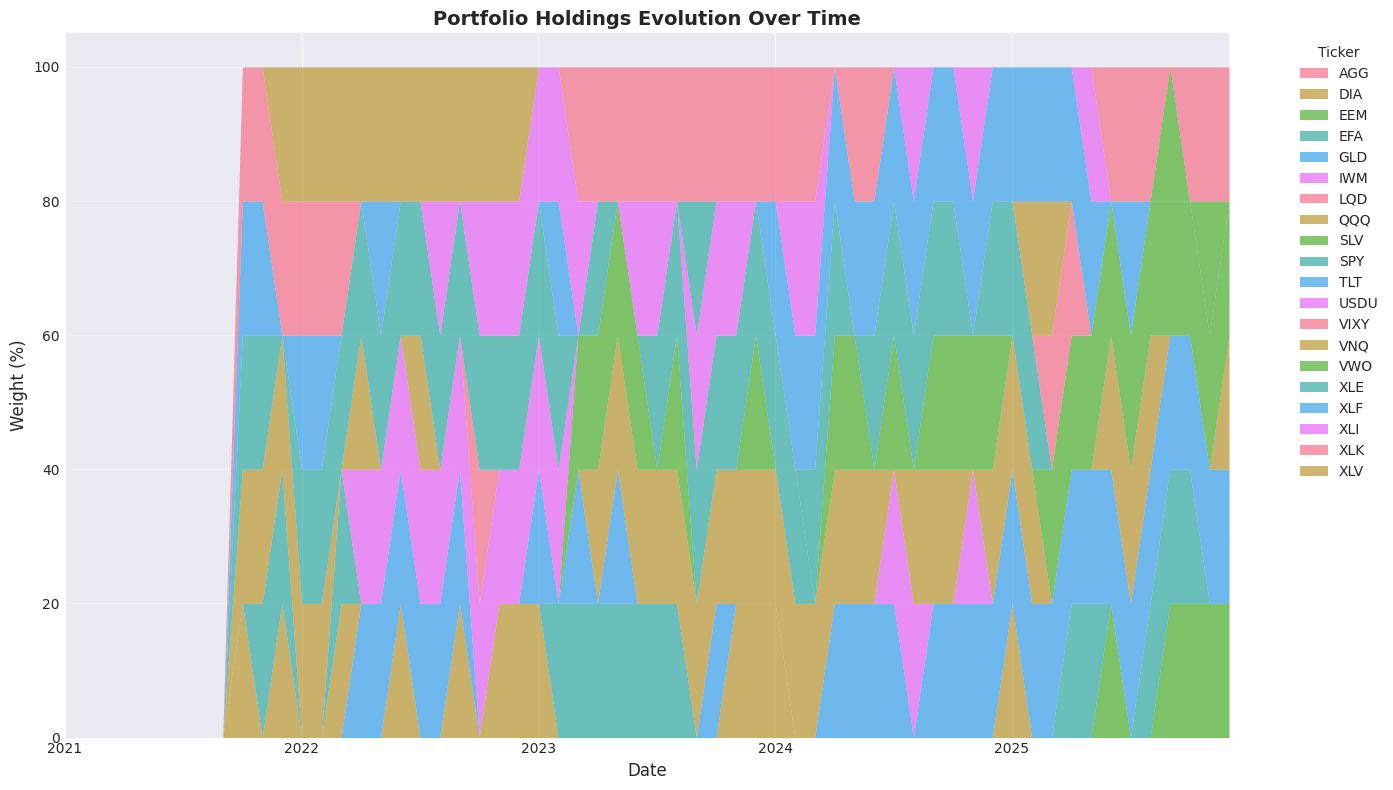


Top 10 Holdings by Average Weight:
GLD   : 10.00% (held 50.0% of time)
QQQ   :  9.33% (held 46.7% of time)
XLK   :  9.00% (held 45.0% of time)
XLF   :  8.00% (held 40.0% of time)
SLV   :  7.67% (held 38.3% of time)
XLE   :  6.67% (held 33.3% of time)
SPY   :  6.33% (held 31.7% of time)
USDU  :  4.67% (held 23.3% of time)
XLI   :  4.67% (held 23.3% of time)
XLV   :  4.33% (held 21.7% of time)

Average Number of Positions: 4.2


In [11]:
# Use weights for cleaner visualization
weights_pct = weights_df * 100

# Create stacked area chart
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked area
weights_pct.plot.area(ax=ax, stacked=True, alpha=0.7, linewidth=0)

plt.title('Portfolio Holdings Evolution Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weight (%)', fontsize=12)
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Calculate holding statistics
avg_weights = weights_df.mean().sort_values(ascending=False)
hold_frequency = (weights_df > 0.001).mean().sort_values(ascending=False)

print("\nTop 10 Holdings by Average Weight:")
for ticker, weight in avg_weights.head(10).items():
    freq = hold_frequency[ticker]
    print(f"{ticker:6s}: {weight:6.2%} (held {freq:.1%} of time)")

print(f"\nAverage Number of Positions: {(weights_df > 0.001).sum(axis=1).mean():.1f}")

## 8. Turnover Analysis

Analyzes portfolio turnover and trading activity.

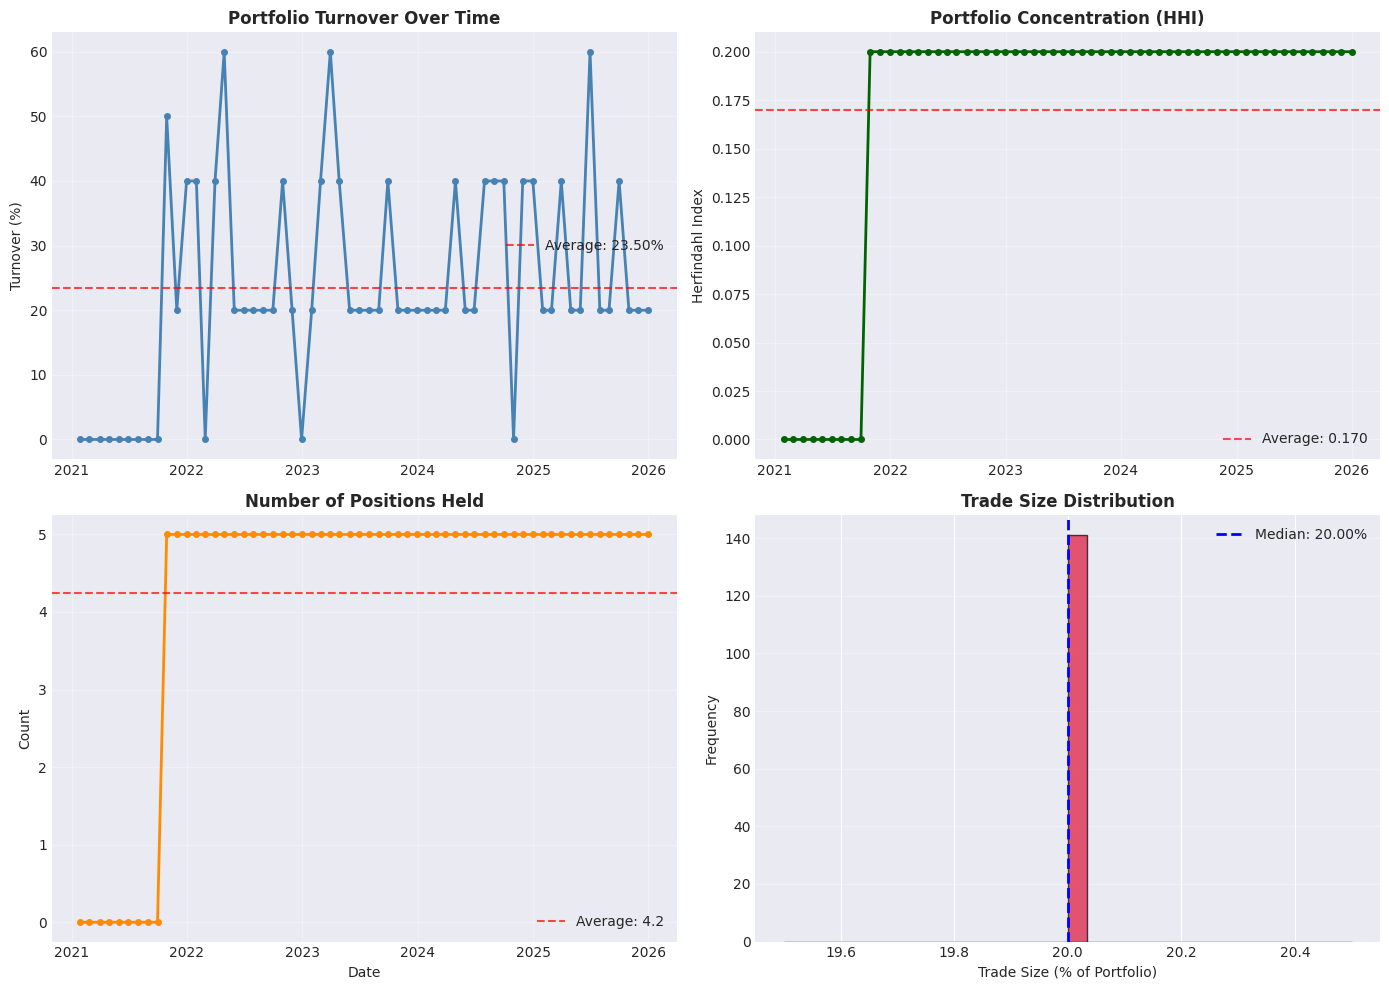


Turnover Statistics:
Average Turnover per Rebalance: 23.50%
Total Turnover: 1410.00%
Annualized Turnover: 5922.00%
Max Single Rebalance Turnover: 60.00%

Concentration Statistics:
Average HHI: 0.170
Average Effective N: inf
Average Positions: 4.2

Trade Statistics:
Total Trades: 141
Median Trade Size: 20.00%
Average Trade Size: 20.00%
Largest Trade: 20.00%


In [12]:
# Calculate turnover (sum of absolute weight changes / 2)
weight_changes = weights_df.diff().abs()
turnover = weight_changes.sum(axis=1) / 2

# Create subplot for turnover metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Turnover over time
ax1.plot(turnover.index, turnover.values * 100, linewidth=2, color='steelblue', marker='o', markersize=4)
ax1.set_title('Portfolio Turnover Over Time', fontweight='bold')
ax1.set_ylabel('Turnover (%)', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(turnover.mean() * 100, color='red', linestyle='--', 
            label=f'Average: {turnover.mean():.2%}', alpha=0.7)
ax1.legend()

# 2. Portfolio concentration (HHI)
hhi = (weights_df ** 2).sum(axis=1)
effective_n = 1 / hhi

ax2.plot(hhi.index, hhi.values, linewidth=2, color='darkgreen', marker='o', markersize=4)
ax2.set_title('Portfolio Concentration (HHI)', fontweight='bold')
ax2.set_ylabel('Herfindahl Index', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(hhi.mean(), color='red', linestyle='--', 
            label=f'Average: {hhi.mean():.3f}', alpha=0.7)
ax2.legend()

# 3. Number of positions
num_positions = (weights_df > 0.001).sum(axis=1)
ax3.plot(num_positions.index, num_positions.values, linewidth=2, 
         color='darkorange', marker='o', markersize=4)
ax3.set_title('Number of Positions Held', fontweight='bold')
ax3.set_ylabel('Count', fontsize=10)
ax3.set_xlabel('Date', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.axhline(num_positions.mean(), color='red', linestyle='--', 
            label=f'Average: {num_positions.mean():.1f}', alpha=0.7)
ax3.legend()

# 4. Trade size distribution
all_trades = weight_changes.values.flatten()
all_trades = all_trades[all_trades > 0.001]  # Filter out tiny changes

ax4.hist(all_trades * 100, bins=30, color='crimson', alpha=0.7, edgecolor='black')
ax4.set_title('Trade Size Distribution', fontweight='bold')
ax4.set_xlabel('Trade Size (% of Portfolio)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.axvline(np.median(all_trades) * 100, color='blue', linestyle='--',
            label=f'Median: {np.median(all_trades):.2%}', linewidth=2)
ax4.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nTurnover Statistics:")
print(f"Average Turnover per Rebalance: {turnover.mean():.2%}")
print(f"Total Turnover: {turnover.sum():.2%}")
print(f"Annualized Turnover: {turnover.sum() / (len(equity_df) / 252):.2%}")
print(f"Max Single Rebalance Turnover: {turnover.max():.2%}")

print("\nConcentration Statistics:")
print(f"Average HHI: {hhi.mean():.3f}")
print(f"Average Effective N: {effective_n.mean():.2f}")
print(f"Average Positions: {num_positions.mean():.1f}")

print("\nTrade Statistics:")
print(f"Total Trades: {len(all_trades)}")
print(f"Median Trade Size: {np.median(all_trades):.2%}")
print(f"Average Trade Size: {np.mean(all_trades):.2%}")
print(f"Largest Trade: {np.max(all_trades):.2%}")

## Summary

This analysis provides a comprehensive view of the backtest performance including:

- **Equity Performance**: Overall returns and drawdown patterns
- **Risk Metrics**: Sharpe ratio evolution and return distributions
- **Portfolio Characteristics**: Holdings, turnover, and concentration
- **Underwater Analysis**: Time spent below previous highs

The visualizations help identify strengths, weaknesses, and areas for strategy improvement.